In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
# Conecta ao banco de dados SQLite
conn = sqlite3.connect('../hermes_db.sqlite')

# Query para unir os dados de todas as medições com os tipos de sensores
query = """
SELECT 'nivel' as tipo, nivel_cm as medicao, status FROM MEDICAO_NIVEL
UNION ALL
SELECT 'temperatura' as tipo, medicao, status FROM MEDICAO_TEMPERATURA
UNION ALL
SELECT 'vibracao' as tipo, aceleracao_total as medicao, status FROM MEDICAO_VIBRACAO;
"""

# Carrega os dados em um DataFrame do Pandas
df = pd.read_sql_query(query, conn)

# Fecha a conexão
conn.close()

# Exibe as primeiras linhas e informações do DataFrame
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tipo     1500 non-null   object 
 1   medicao  1500 non-null   float64
 2   status   1500 non-null   object 
dtypes: float64(1), object(2)
memory usage: 35.3+ KB
None


,tipo,medicao,status
0,nivel,25.00,NORMAL
1,nivel,1.85,FALHA_CRITICA
2,nivel,1.85,FALHA_CRITICA
3,nivel,1.85,FALHA_CRITICA
4,nivel,1.85,FALHA_CRITICA


In [3]:
# O Machine Learning funciona com números. Precisamos transformar as colunas de texto.

# 1. Converter a coluna 'tipo' em colunas numéricas (One-Hot Encoding)
df_encoded = pd.get_dummies(df, columns=['tipo'], drop_first=True)

# 2. Converter a coluna alvo 'status' em números (Label Encoding)
label_encoder = LabelEncoder()
df_encoded['status_encoded'] = label_encoder.fit_transform(df_encoded['status'])

# Exibe o mapeamento das classes
print("Mapeamento das classes de status:")
for index, class_name in enumerate(label_encoder.classes_):
    print(f"{index}: {class_name}")

df_encoded.head()

Mapeamento das classes de status:
0: ALERTA_Pre_falha
1: FALHA_CRITICA
2: NORMAL


,medicao,status,tipo_temperatura,tipo_vibracao,status_encoded
0,25.00,NORMAL,False,False,2
1,1.85,FALHA_CRITICA,False,False,1
2,1.85,FALHA_CRITICA,False,False,1
3,1.85,FALHA_CRITICA,False,False,1
4,1.85,FALHA_CRITICA,False,False,1


In [4]:
# Features (X) são as colunas que usamos para prever
X = df_encoded[['medicao', 'tipo_temperatura', 'tipo_vibracao']]

# Alvo (y) é a coluna que queremos prever
y = df_encoded['status_encoded']

In [5]:
# Dividimos os dados para treinar o modelo em uma parte e testá-lo em outra,
# garantindo uma avaliação justa de sua performance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")

Tamanho do conjunto de treino: 1050 amostras
Tamanho do conjunto de teste: 450 amostras


In [6]:
# Escolhemos uma Árvore de Decisão por ser um modelo simples e fácil de interpretar.
# O objetivo é criar um conjunto de regras para classificar o status.
model = DecisionTreeClassifier(random_state=42)

# Treina o modelo com os dados de treino
model.fit(X_train, y_train)

print("Modelo de Árvore de Decisão treinado com sucesso!")

Modelo de Árvore de Decisão treinado com sucesso!


In [7]:
# Faz previsões nos dados de teste, que o modelo nunca viu antes
y_pred = model.predict(X_test)

# Calcula a acurácia: a porcentagem de previsões corretas
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy * 100:.2f}%")

# A acurácia alta é esperada, pois os dados foram gerados com regras claras.
# Em um cenário real, este valor seria mais desafiador.

Acurácia do modelo: 100.00%


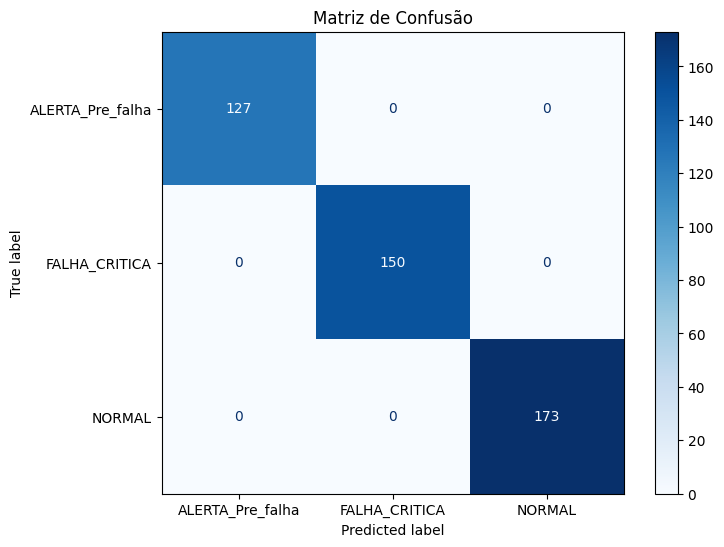

In [8]:
# A Matriz de Confusão é a melhor forma de visualizar a performance de um modelo de classificação.
# Ela mostra exatamente onde o modelo acertou e onde errou.

cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão')
plt.show()

# Justificativa do Gráfico:
# A Matriz de Confusão foi escolhida por ser a ferramenta padrão para avaliar modelos de classificação.
# A diagonal principal (do canto superior esquerdo ao inferior direito) mostra o número de previsões corretas para cada classe.
# Os valores fora da diagonal indicam os erros (ex: quando o modelo previu 'NORMAL' mas o valor real era 'ALERTA').
# Este gráfico nos dá uma visão detalhada e precisa da performance do modelo para cada status,
# o que é muito mais informativo que apenas a acurácia geral.